In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1.2, color_codes=True, rc=None)

## read data

In [3]:
data = pd.read_csv('../data/monthly_GHI_virum_v2.csv', skiprows=1, header=None)
data = data.drop(columns=data.columns[0]) # Drop the first column
data.insert(0, "Month", range(1,13)) # Insert a new column with the month number
data = data.rename(columns={1: 'GHI'}) # Rename the second column to GHI
data

data["Month"] = pd.to_datetime(data["Month"], format='%m').dt.month
print("\nNew Layout:\n")
data


New Layout:



Month       GHI
0       1   11.5874
1       2   32.1667
2       3   90.4651
3       4  172.5350
4       5  214.8620
5       6  242.3860
6       7  220.8480
7       8  170.3680
8       9  120.0310
9      10   43.0672
10     11   15.2264
11     12    6.5578

In [4]:
data.to_csv('../data/monthly_GHI_virum_new.csv', index=False, sep=';')

In [5]:
days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
data["H"]= (data["GHI"] * 24 / 1_000)
data

Month       GHI         H
0       1   11.5874  0.278098
1       2   32.1667  0.772001
2       3   90.4651  2.171162
3       4  172.5350  4.140840
4       5  214.8620  5.156688
5       6  242.3860  5.817264
6       7  220.8480  5.300352
7       8  170.3680  4.088832
8       9  120.0310  2.880744
9      10   43.0672  1.033613
10     11   15.2264  0.365434
11     12    6.5578  0.157387

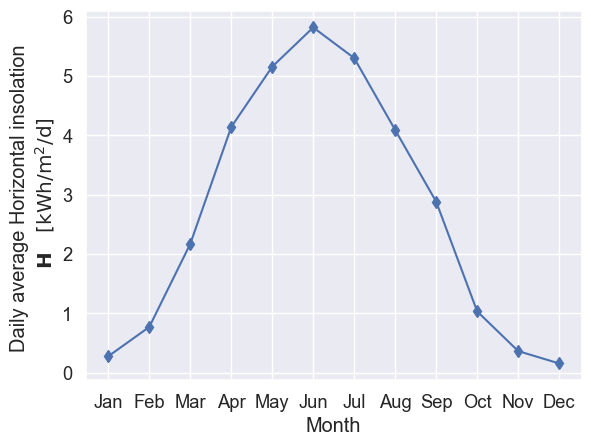

In [6]:
fig, ax = plt.subplots()
data.plot(x="Month", y="H", xlabel=r"Month", 
               ylabel="Daily average Horizontal insolation \n $\\mathbf{H}\\quad \\left[\\mathrm{kWh/m^2/d}\\right]$", ax=ax, legend=None, marker='d')
xtick_label = list(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.set_xticks(range(1,13))
ax.set_xticklabels(xtick_label); 

Jan    0.653197
Feb    0.562870
Mar    0.554000
Apr    0.497575
May    0.489206
Jun    0.490409
Jul    0.484142
Aug    0.477913
Sep    0.508934
Oct    0.592630
Nov    0.613331
Dec    0.657523
dtype: float64


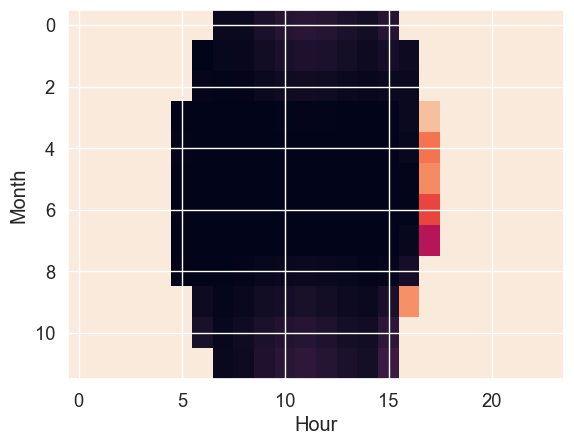

In [7]:
filename = '../data/Shading_SAM_Lyngby.csv'
filename = '../data/shading_factors.csv'
shading = pd.read_csv(filename, header=None)
fig, ax = plt.subplots(1,1)
# ax[0].imshow(shading, aspect='auto')
# ax[0].set_ylabel("Month")
# ax[0].set_xlabel("Hour")
shading.index = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
shading_norm = shading / 100 # Normalize the shading factors to be between 0 and 1
ax.imshow(shading_norm, aspect='auto')
ax.set_ylabel("Month")
ax.set_xlabel("Hour")
print(shading_norm.mean(axis=1))
shading_norm.mean(axis=1).to_csv("../data/shading_factors_mean.csv", header=False, sep=";")

# 1.c Optimal tilt angle

In [8]:
tilt_data = pd.read_csv('../data/tilt.csv', index_col=0, header=None).T

tilt_data.sort_values(by="tilt", inplace=True)


(10.0, 90.0)

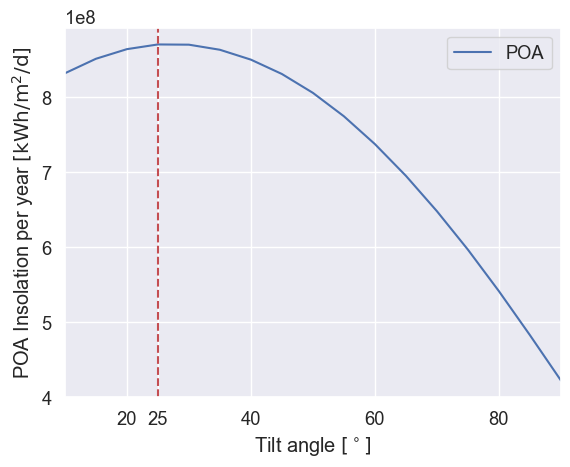

In [9]:
fig, ax = plt.subplots()
tilt_data.plot(x="tilt", y="POA", ax=ax)
ax.set_xlabel(r"Tilt angle $[^\circ]$")
ax.set_ylabel(r"POA Insolation per year $[\mathrm{kWh/m^2/d}]$")

maxid = tilt_data.POA.idxmax()
ax.axvline(x=tilt_data.tilt[maxid], color='r', linestyle='--')
xticks = ax.get_xticks()

xticks = np.append(xticks, tilt_data.tilt[maxid])
xticks.sort()
ax.set_xticks(xticks)
ax.set_xlim(10, 90)

## f)

   month        POA      norm
0    Jan   12.86340  0.414948
1    Feb   29.46950  1.052482
2    Mar   83.14370  2.682055
3    Apr  139.30800  4.643600
4    May  167.98200  5.418774
5    Jun  180.93100  6.031033
6    Jul  170.59300  5.503000
7    Aug  137.99100  4.451323
8    Sep  102.50300  3.416767
9    Oct   39.74610  1.282132
10   Nov   15.60190  0.520063
11   Dec    6.53612  0.210843


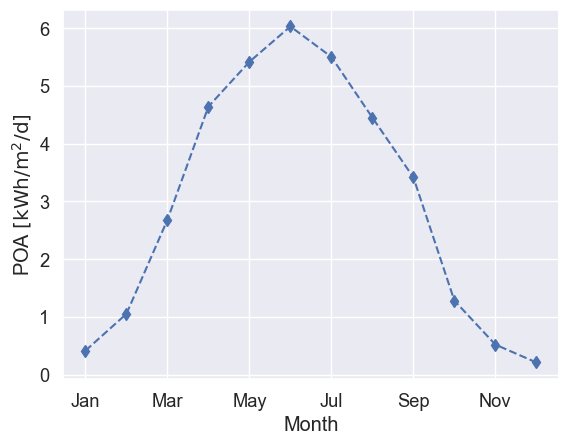

In [10]:
filename = "../data/POA_SAM.csv"
POA = pd.read_csv(filename, names=["month", "POA"], skiprows=1)
POA["norm"] = POA.POA / days_in_month
print(POA)
fig, ax = plt.subplots()
POA.plot(x="month", y="norm", ax=ax, marker='d', legend=None, linestyle='--')
ax.set_xlabel("Month")
ax.set_ylabel("POA $[\\mathrm{kWh/m^2/d}]$")
None

## 1.h)

6931.200000000001


array([ 6. ,  7. ,  8. ,  8.7, 10. , 11. , 12. ])

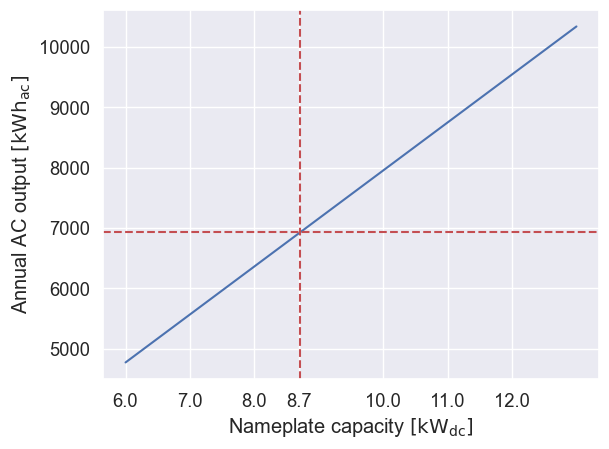

In [83]:
capacity = pd.read_csv("../data/nameplate.csv", names=["capacity", "AC"], skiprows=1, header=None)
X = np.column_stack([np.ones_like(capacity.capacity), capacity.capacity])
y = capacity.AC
C = np.linalg.solve(X.T @ X, X.T @ y)
offset, slope = C
f = lambda x: slope*x + offset
xs = np.linspace(6, 12, 10_000)
fig, ax = plt.subplots()
# capacity.plot(x="capacity", y="AC", legend=None, ax=ax)
# ax.plot(capacity.capacity, capacity.AC, 'o', label="Data")
ax.plot(capacity.capacity, f(capacity.capacity), label="Linear fit")
ax.set_xlabel("Nameplate capacity $\\left[\\mathrm{kW_{dc}}\\right]$")
ax.set_ylabel("Annual AC output $\\left[\\mathrm{kWh_{ac}}\\right]$")

energy_avg_day = 0.8*8664
ax.axhline(y=energy_avg_day, color='r', linestyle='--')
idx = (f(xs) <= energy_avg_day)
print(energy_avg_day)
ax.axvline(x=xs[idx].max(), color='r', linestyle='--')
ax.set_xticks(np.round(np.sort(list(range(6, 9)) + list(range(10,13)) + [xs[idx].max()]), 1))
ax.get_xticks()
# ax.set_xticklabels(np.sort())

# None